In [15]:
%load_ext autoreload
%autoreload 2
import sys
import os
root_path = '../'
sys.path.append(os.path.join(root_path, 'code'))

sys.path.append("/dfs/scratch0/mfchen/metal-ama")

import pandas as pd
import sklearn
import numpy as np

from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import snorkel

from sklearn import metrics

from metal import LabelModel

import matplotlib.pyplot as plt 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load data
df=pd.read_csv('anomaly.csv', sep=',',header=None)
df2=pd.read_csv('noisesimulation1.csv', sep=',',header=None)
df3 = pd.read_csv('noisesimulation2.csv', sep=',',header=None)

In [104]:
# Each row is a collision event summarized by 5 features.  The first feature is “m” and the other four features are “x”.   I would suggest using 3.3 < m. <3.7 as the signal region and everything else as the sideband.  So if you want mixed samples, you can call all noise/anomaly in the signal region as class 1 and then everything else as class 0.  
# set up the datasets according to the above
X1 = df.to_numpy()
X2 = df2.to_numpy()

# construct training data
n1 = X1.shape[0]
n2 = X2.shape[0]

# construct train-test split
shuffled_anomaly_idx = np.random.permutation(np.arange(n1))
shuffled_background_idx = np.random.permutation(np.arange(n2))

n_train_anomaly = int(n1 * 0.3)
n_train_background = int(n2 * 0.5)

# more balanced test dataset
n_test_anomaly = int(n1 *0.3)
n_test_background = n_train_background


X_train_anomaly = X1[shuffled_anomaly_idx][: n_train_anomaly, :]
X_train_background = X2[shuffled_background_idx][: n_train_background, :]

X_test_anomaly = X1[shuffled_anomaly_idx][n_test_anomaly : , :]
X_test_background = X2[shuffled_background_idx][n_test_background : , :]


X_train = np.concatenate((X_train_anomaly, X_train_background))
n_train = len(X_train)

print(f"Proportion of anomaly in the training data: {len(X_train_anomaly) / n_train}")

X_test = np.concatenate((X_test_anomaly, X_test_background))
n_test = len(X_test)

print(f"Proportion of anomaly in the test data: {len(X_test_anomaly) / n_test}")


Y_test_true = np.zeros(n_test)
Y_test_true[:len(X_test_anomaly)] = 1

Proportion of anomaly in the training data: 0.14844313806054668
Proportion of anomaly in the test data: 0.2891435406067375


In [55]:
# we want to test performance with different sample sizes 
n_pts = 20
n_ratios = list(np.logspace(0.5, 2.5, num=n_pts)/10**4)
#n_ratios = np.linspace(0.0005, 0.06,num=n_pts)
print(n_ratios[0]*n_train, n_ratios[-1]*n_train)

60.031730417338466 6003.173041733848


Standard cwola (k = 1)

In [56]:
# run a cwola-like model and evaluate
# let's also construct smaller versions
num_runs = 5
cwola_scores = np.zeros((n_pts, num_runs))
cwola_aucs = np.zeros((n_pts, num_runs))

X_test_discriminative = X_test[:, 1:]

for a in range(len(n_ratios)):
    for b in range(num_runs):
        n1a = int(n_ratios[a]*n_train_anomaly)
        n2a = int(n_ratios[a]*n_train_background)
        print(f"Testing with training set size {n1a+n2a}")
        
        X = np.concatenate((X_train_anomaly[np.random.permutation(n_train_anomaly)][:n1a], X_train_background[np.random.permutation(n_train_background)][:n2a]))
        Y = np.zeros(n1a+n2a)
        for i in range(n1a+n2a):
            Y[i] = 1 if (X[i, 0] > 3.3 and X[i,0] < 3.7) else 0
        
        # Ignore the resonant feature and train using Y 
        X_discriminative = X[:, 1:]
        clf = make_pipeline(StandardScaler(), MLPClassifier(max_iter=5000))
        clf.fit(X_discriminative, Y)
            
        # evaluate on true data    
        cwola_scores[a, b] = metrics.accuracy_score(Y_test_true, clf.predict(X_test_discriminative))
        cwola_aucs[a, b] = metrics.roc_auc_score(Y_test_true, clf.predict_proba(X_test_discriminative)[:, 1])

        
        print(f"Cwola accuracy: {cwola_scores[a,b]}")
        print(f"Cwola AUC: {cwola_aucs[a,b]}")
        
cwola_accs = cwola_scores.sum(axis=1) / num_runs
cwola_stds= cwola_scores.std(axis=1)

cwola_auc_mean = cwola_aucs.sum(axis = 1)/ num_runs
cwola_auc_std = cwola_aucs.std(axis=1)

print(f"Cwola accuracy = {cwola_accs} std = {cwola_stds}")
print(f"Cwola AUC = {cwola_auc_mean} std = {cwola_auc_std}")


Testing with training set size 59
Cwola accuracy: 0.4949541143206413
Cwola AUC: 0.4958223867666639
Testing with training set size 59
Cwola accuracy: 0.5696903870930862
Cwola AUC: 0.6940093115508194
Testing with training set size 59
Cwola accuracy: 0.651035780716142
Cwola AUC: 0.6544912815523332
Testing with training set size 59
Cwola accuracy: 0.6529793811259691
Cwola AUC: 0.7449211241790763
Testing with training set size 59
Cwola accuracy: 0.5564985291078346
Cwola AUC: 0.7302872053715638
Testing with training set size 76
Cwola accuracy: 0.5992841218400004
Cwola AUC: 0.7156211998849512
Testing with training set size 76
Cwola accuracy: 0.5187302396960596
Cwola AUC: 0.5818414121171014
Testing with training set size 76
Cwola accuracy: 0.6290405561687327
Cwola AUC: 0.7160787206231853
Testing with training set size 76
Cwola accuracy: 0.6790596843628113
Cwola AUC: 0.6484065945776432
Testing with training set size 76
Cwola accuracy: 0.6115613443382745
Cwola AUC: 0.7354067534943991
Testing wit

Now, using k = 3

In [153]:
# specify the thresholds
thresholds = np.array([[3.3, 3.7], [0.09, 0.13], [0.3, 0.35]])


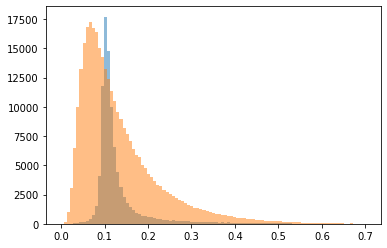

In [21]:
bins = np.linspace(0, 0.7, 100)


plt.hist(X1[:, 1], bins, alpha = 0.5)
plt.hist(X2[:, 1], bins, alpha = 0.5)
plt.show()

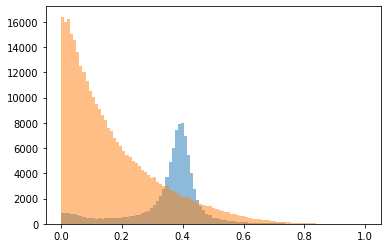

In [22]:
bins = np.linspace(0, 1, 100)


plt.hist(X1[:, 2], bins, alpha = 0.5)
plt.hist(X2[:, 2], bins, alpha = 0.5)
plt.show()

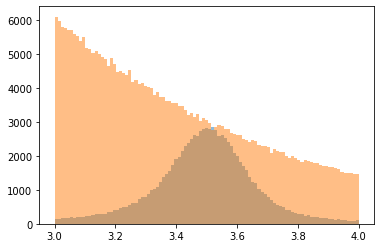

In [61]:
bins = np.linspace(3, 4, 100)


plt.hist(X1[:, 0], bins, alpha = 0.5)
plt.hist(X2[:, 0], bins, alpha = 0.5)
plt.show()

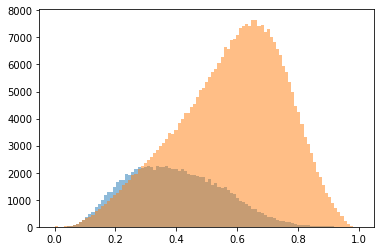

In [78]:
bins = np.linspace(0, 1, 100)


plt.hist(X1[:, 3], bins, alpha = 0.5)
plt.hist(X2[:, 3], bins, alpha = 0.5)
plt.show()

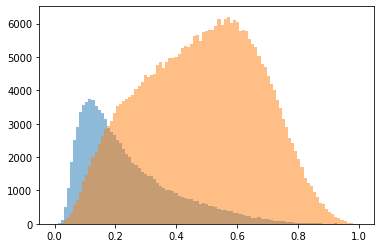

In [80]:
bins = np.linspace(0, 1, 100)


plt.hist(X1[:, 4], bins, alpha = 0.5)
plt.hist(X2[:, 4], bins, alpha = 0.5)
plt.show()

First, make 1 threshold the y, and make the other k - 1 thresholds just discriminative features. The argument here is that we have the exact same amount of information between Multi-CWOLA and this baseline.

In [161]:
# run a cwola-like model and evaluate
# let's also construct smaller versions
num_runs = 5
disc_thresh_scores = np.zeros((n_pts, num_runs))
disc_thresh_aucs = np.zeros((n_pts, num_runs))

# Change discriminative features into thresholded features
X_test_discriminative = X_test[:, 1:]
for i in range(len(X_test_discriminative)):
    for j in [0, 1]:
        if thresholds[j+1][0] < X_test_discriminative[i, j] < thresholds[j+1][1]:
            X_test_discriminative[i, j] = 1 
        else:
            X_test_discriminative[i,j] = 0

for a in range(len(n_ratios)):
    for b in range(num_runs):
        n1a = int(n_ratios[a]*n_train_anomaly)
        n2a = int(n_ratios[a]*n_train_background)
        print(f"Testing with training set size {n1a+n2a}")
        X = np.concatenate((X_train_anomaly[np.random.permutation(n_train_anomaly)][:n1a], X_train_background[np.random.permutation(n_train_background)][:n2a]))
        Y = np.zeros(n1a+n2a)
        for i in range(n1a+n2a):
            Y[i] = 1 if (X[i, 0] > 3.3 and X[i,0] < 3.7) else 0
        Y_true=np.zeros(n1a+n2a)
        Y_true[:n1a] = 1 # anomaly
        
        # Change discriminative features into thresholded features 
        X_discriminative = X[:, 1:]   
        for i in range(len(X_discriminative)):
            for j in [0, 1]:
                if thresholds[j+1][0] < X_discriminative[i, j] < thresholds[j+1][1]:
                    X_discriminative[i, j] = 1 
                else:
                    X_discriminative[i,j] = 0 
    
        clf = make_pipeline(StandardScaler(), MLPClassifier(max_iter=5000))
        clf.fit(X_discriminative, Y)
            
        # evaluate on true data    
        disc_thresh_scores[a, b] = metrics.accuracy_score(Y_test_true, clf.predict(X_test_discriminative))
        disc_thresh_aucs[a, b] = metrics.roc_auc_score(Y_test_true, clf.predict_proba(X_test_discriminative)[:, 1])
        
        print(f"Cwola accuracy: {disc_thresh_scores[a,b]}")
        print(f"Cwola AUC: {disc_thresh_aucs[a,b]}")

        
        
disc_thresh_accs = disc_thresh_scores.sum(axis=1) / num_runs
disc_thresh_stds= disc_thresh_scores.std(axis=1)

disc_thresh_auc_mean = disc_thresh_aucs.sum(axis = 1)/ num_runs
disc_thresh_auc_std = disc_thresh_aucs.std(axis = 1)

print(f"Disc thresh accuracy = {disc_thresh_accs} std = {disc_thresh_stds}")
print(f"Disc thresh accuracy = {disc_thresh_auc_mean} std = {disc_thresh_auc_std}")



Testing with training set size 59
Cwola accuracy: 0.4522784537383527
Cwola AUC: 0.30297470170475926
Testing with training set size 59
Cwola accuracy: 0.6423731273058269
Cwola AUC: 0.6568465903697902
Testing with training set size 59
Cwola accuracy: 0.6203339298984667
Cwola AUC: 0.4782525943927418
Testing with training set size 59
Cwola accuracy: 0.7450013851450884
Cwola AUC: 0.6859693955414844
Testing with training set size 59
Cwola accuracy: 0.5733357371830107
Cwola AUC: 0.5497266868102406
Testing with training set size 76
Cwola accuracy: 0.4888726677894404
Cwola AUC: 0.495137805880375
Testing with training set size 76
Cwola accuracy: 0.6447784427451377
Cwola AUC: 0.6760170568202912
Testing with training set size 76
Cwola accuracy: 0.6315470091859304
Cwola AUC: 0.7327537488283704
Testing with training set size 76
Cwola accuracy: 0.6340050920571824
Cwola AUC: 0.8014029816580772
Testing with training set size 76
Cwola accuracy: 0.6771424676689547
Cwola AUC: 0.5913013814505352
Testing wi

Second, try cwola and then averaging the scores

In [176]:
# run a cwola-like model and evaluate
# let's also construct smaller versions
num_runs = 5
mv_aucs = np.zeros((n_pts, num_runs))

m = 3

# Change discriminative features into thresholded features
X_test_discriminative = X_test[:, m:]


for a in range(len(n_ratios)):
    for b in range(num_runs):
        n1a = int(n_ratios[a]*n_train_anomaly)
        n2a = int(n_ratios[a]*n_train_background)
        print(f"Testing with training set size {n1a+n2a}")
        X = np.concatenate((X_train_anomaly[np.random.permutation(n_train_anomaly)][:n1a], X_train_background[np.random.permutation(n_train_background)][:n2a]))
        Y = np.zeros((n1a+n2a, 3))
        for i in range(n1a+n2a):
            Y[i, 0] = 1 if (X[i, 0] > thresholds[0, 0] and X[i,0] < thresholds[0, 1]) else 0
            Y[i, 1] = 1 if (X[i, 1] > thresholds[1, 0] and X[i,1] < thresholds[1, 1]) else 0
            Y[i, 2] = 1 if (X[i, 2] > thresholds[2, 0] and X[i,2] < thresholds[2, 1]) else 0

        Y_true=np.zeros(n1a+n2a)
        Y_true[:n1a] = 1 # anomaly
        
        # Change discriminative features into thresholded features 
        X_discriminative = X[:, m:]   

    
        clf1 = make_pipeline(StandardScaler(), MLPClassifier(max_iter=5000))
        clf1.fit(X_discriminative, Y[:, 0])

        clf2 = make_pipeline(StandardScaler(), MLPClassifier(max_iter=5000))
        clf2.fit(X_discriminative, Y[:, 1])

        clf3 = make_pipeline(StandardScaler(), MLPClassifier(max_iter=5000))
        clf3.fit(X_discriminative, Y[:, 2])

        
        avg_probs = (clf1.predict_proba(X_test_discriminative)[:, 1] + clf2.predict_proba(X_test_discriminative)[:, 1] + clf3.predict_proba(X_test_discriminative)[:, 1])/3

            
        # evaluate on true data    
        mv_aucs[a, b] = metrics.roc_auc_score(Y_test_true, avg_probs)
        
        print(f"Cwola MV AUC: {mv_aucs[a,b]}")

        
        
mv_auc_mean = mv_aucs.sum(axis = 1)/ num_runs
mv_auc_std = mv_aucs.std(axis = 1)


Testing with training set size 59
Cwola MV AUC: 0.7791507048398034
Testing with training set size 59
Cwola MV AUC: 0.565089790183585
Testing with training set size 59
Cwola MV AUC: 0.7646115197007457
Testing with training set size 59
Cwola MV AUC: 0.5958268885521927
Testing with training set size 59
Cwola MV AUC: 0.726674999694421
Testing with training set size 76
Cwola MV AUC: 0.8010466498140605
Testing with training set size 76
Cwola MV AUC: 0.7388660379413566
Testing with training set size 76
Cwola MV AUC: 0.6370266082325355
Testing with training set size 76
Cwola MV AUC: 0.6340825364862489
Testing with training set size 76
Cwola MV AUC: 0.6177587116444029
Testing with training set size 97
Cwola MV AUC: 0.6920033001795037
Testing with training set size 97
Cwola MV AUC: 0.7590256189045668
Testing with training set size 97
Cwola MV AUC: 0.7909376880531879
Testing with training set size 97
Cwola MV AUC: 0.796217740448121
Testing with training set size 97
Cwola MV AUC: 0.836211596356405

Finally, we do Multi-CWoLa.
In this cell below, we also look at CWoLa-intersect.

In [69]:
from metal import LabelModel

In [156]:
# snorkel approach
import logging, sys, time
from tqdm import tqdm
from snorkel.utils import probs_to_preds

from functools import partialmethod

logging.disable(sys.maxsize)
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

m = 3

num_runs=5

label_model = LabelModel(k=2)

X_test_discriminative = X_test[:, m:]

snorkel_scores = np.zeros((n_pts, num_runs))
snorkel_aucs = np.zeros((n_pts, num_runs))

intersect_scores = np.zeros((n_pts, num_runs))
intersect_aucs = np.zeros((n_pts, num_runs))

for a in range(len(n_ratios)):
    for b in range(num_runs):
        n1a = int(n_ratios[a]*n_train_anomaly)
        n2a = int(n_ratios[a]*n_train_background)
        X = np.concatenate((X_train_anomaly[np.random.permutation(n_train_anomaly)][:n1a], X_train_background[np.random.permutation(n_train_background)][:n2a]))
        
        X_discriminative = X[:, m:]

        # make each feature a separate LF in here
        L = np.zeros((n1a+n2a, m))
        
        Y = np.zeros(n1a+n2a)
        for i in range(n1a+n2a):
            # take intersection over thresholds to create noisy label
            flag = True 
            for j in [0, 1, 2]:
                if thresholds[j][0] > X[i, j] or X[i, j ] > thresholds[j][1]:
                    flag = False
            if flag:
                Y[i] = 1
        
        
        for i in range(n1a+n2a):
            L[i, 0] = 1 if (X[i, 0] > thresholds[0,0] and X[i, 0] < thresholds[0,1]) else 0
            L[i, 1] = 1 if (X[i, 1] > thresholds[1,0] and X[i, 1] < thresholds[1,1]) else 0
            L[i, 2] = 1 if (X[i, 2] > thresholds[2,0] and X[i, 2] < thresholds[2,1]) else 0
            
        L_scaled = L + 1
        
        # we use these to get the class balance.
        Y_true=np.zeros(n1a+n2a)
        Y_true[:n1a] = 1 # anomaly

        label_model.train_model(L_scaled, Y_dev=[0.75, 0.25], n_epochs=30000, log_train_every=500, lr=0.000001)
        print(label_model.mu)
        
        probs_train = label_model.predict_proba(L_scaled)
        preds_train = probs_to_preds(probs=probs_train).astype(float)
        
        if all(preds_train == 0):
            print("WS output is all 0, using intersect output instead.")
            preds_train = Y
        
        print(Y)
        print(preds_train)
        print(Y_true)


        clf_intersect_model = make_pipeline(StandardScaler(), MLPClassifier(max_iter=5000))
        clf_intersect_model.fit(X_discriminative, Y)


        clf_end_model = make_pipeline(StandardScaler(), MLPClassifier(max_iter=5000))
        clf_end_model.fit(X_discriminative, preds_train)

        snorkel_scores[a, b] = metrics.accuracy_score(Y_test_true, clf_end_model.predict(X_test_discriminative))
        snorkel_aucs[a, b] = metrics.roc_auc_score(Y_test_true, clf_end_model.predict_proba(X_test_discriminative)[:, 1])

        
        intersect_scores[a, b] = metrics.accuracy_score(Y_test_true, clf_intersect_model.predict(X_test_discriminative))
        intersect_aucs[a, b] = metrics.roc_auc_score(Y_test_true, clf_intersect_model.predict_proba(X_test_discriminative)[:, 1])
        

        print(f"snorkel scores: {snorkel_scores[a, b]}")
        print(f"snorkel auc: {snorkel_aucs[a, b]}")
        print(f"Intersect scores: {intersect_scores[a, b]}")
        print(f"Intersect AUCs: {intersect_aucs[a, b]}")


    print(f"With sample size {n1a+n2a}:")
    print(f"snorkel AUCs: {snorkel_aucs[a].mean()}")
    print(f"Intersect AUCs: {intersect_aucs[a].mean()}")

snorkel_accs = snorkel_scores.sum(axis=1) / num_runs
snorkel_stds = snorkel_scores.std(axis=1)
        
snorkel_auc_mean = snorkel_aucs.sum(axis = 1)/ num_runs
snorkel_auc_std = snorkel_aucs.std(axis = 1)


intersect_accs = intersect_scores.sum(axis=1) / num_runs
intersect_stds = intersect_scores.std(axis=1)

intersect_auc_mean = intersect_aucs.sum(axis=1) / num_runs
intersect_auc_std = intersect_aucs.std(axis=1)
    

print(f"Snorkel accuracy = {snorkel_accs} std = {snorkel_stds}")


Using device: cpu
Computing O...
Estimating \mu...
[500 epo]: TRAIN:[loss=22.834]
[1000 epo]: TRAIN:[loss=13.070]
[1500 epo]: TRAIN:[loss=8.109]
[2000 epo]: TRAIN:[loss=5.561]
[2500 epo]: TRAIN:[loss=4.223]
[3000 epo]: TRAIN:[loss=3.492]
[3500 epo]: TRAIN:[loss=3.067]
[4000 epo]: TRAIN:[loss=2.799]
[4500 epo]: TRAIN:[loss=2.613]
[5000 epo]: TRAIN:[loss=2.471]
[5500 epo]: TRAIN:[loss=2.356]
[6000 epo]: TRAIN:[loss=2.256]
[6500 epo]: TRAIN:[loss=2.167]
[7000 epo]: TRAIN:[loss=2.086]
[7500 epo]: TRAIN:[loss=2.012]
[8000 epo]: TRAIN:[loss=1.942]
[8500 epo]: TRAIN:[loss=1.878]
[9000 epo]: TRAIN:[loss=1.817]
[9500 epo]: TRAIN:[loss=1.760]
[10000 epo]: TRAIN:[loss=1.706]
[10500 epo]: TRAIN:[loss=1.655]
[11000 epo]: TRAIN:[loss=1.607]
[11500 epo]: TRAIN:[loss=1.561]
[12000 epo]: TRAIN:[loss=1.517]
[12500 epo]: TRAIN:[loss=1.475]
[13000 epo]: TRAIN:[loss=1.435]
[13500 epo]: TRAIN:[loss=1.397]
[14000 epo]: TRAIN:[loss=1.360]
[14500 epo]: TRAIN:[loss=1.325]
[15000 epo]: TRAIN:[loss=1.291]
[15500 

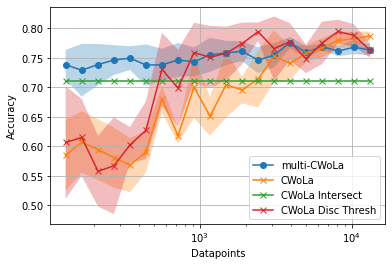

In [166]:
import matplotlib.pyplot as plt
fig = plt.gcf()

#fig.set_size_inches(18.5, 10.5)

n_labels = np.zeros(n_pts)

for a in range(len(n_ratios)):
    n1a = int(n_ratios[a]*n1)
    n2a = int(n_ratios[a]*n2)
    n_labels[a] = n1a+n2a
#fig.set_size_inches(18.5, 10.5, forward=True)

plt.plot(n_labels, snorkel_accs, label='multi-CWoLa', marker="o")
plt.fill_between(n_labels, snorkel_accs-snorkel_stds, snorkel_accs+snorkel_stds, alpha=0.3)


#plt.plot(n_labels, mv_accs, label='Majority Vote', marker="o")
#plt.fill_between(n_labels, mv_accs-mv_stds, mv_accs+mv_stds, alpha=0.3)


#plt.plot(n_labels, lm_accs, label='multi-CWoLa LM', marker="o")
#plt.fill_between(n_labels, lm_accs-lm_stds, lm_accs+lm_stds, alpha=0.3)


plt.plot(n_labels, cwola_accs, label='CWoLa', marker="x")
plt.fill_between(n_labels, cwola_accs-cwola_stds, cwola_accs+cwola_stds, alpha=0.3)

plt.plot(n_labels, intersect_accs, label='CWoLa Intersect', marker="x")
plt.fill_between(n_labels, intersect_accs-intersect_stds, intersect_accs+intersect_stds, alpha=0.3)

plt.plot(n_labels, disc_thresh_accs, label='CWoLa Disc Thresh', marker="x")
plt.fill_between(n_labels, disc_thresh_accs-disc_thresh_stds, disc_thresh_accs+disc_thresh_stds, alpha=0.3)


plt.ylabel('Accuracy')
plt.xlabel('Datapoints')
plt.legend()
plt.grid()
ax = fig.axes[0]
ax.set_xscale('log')
ax.set_rasterized(True)

# fig.savefig('bla.pdf', dpi=300)

#plt.show()


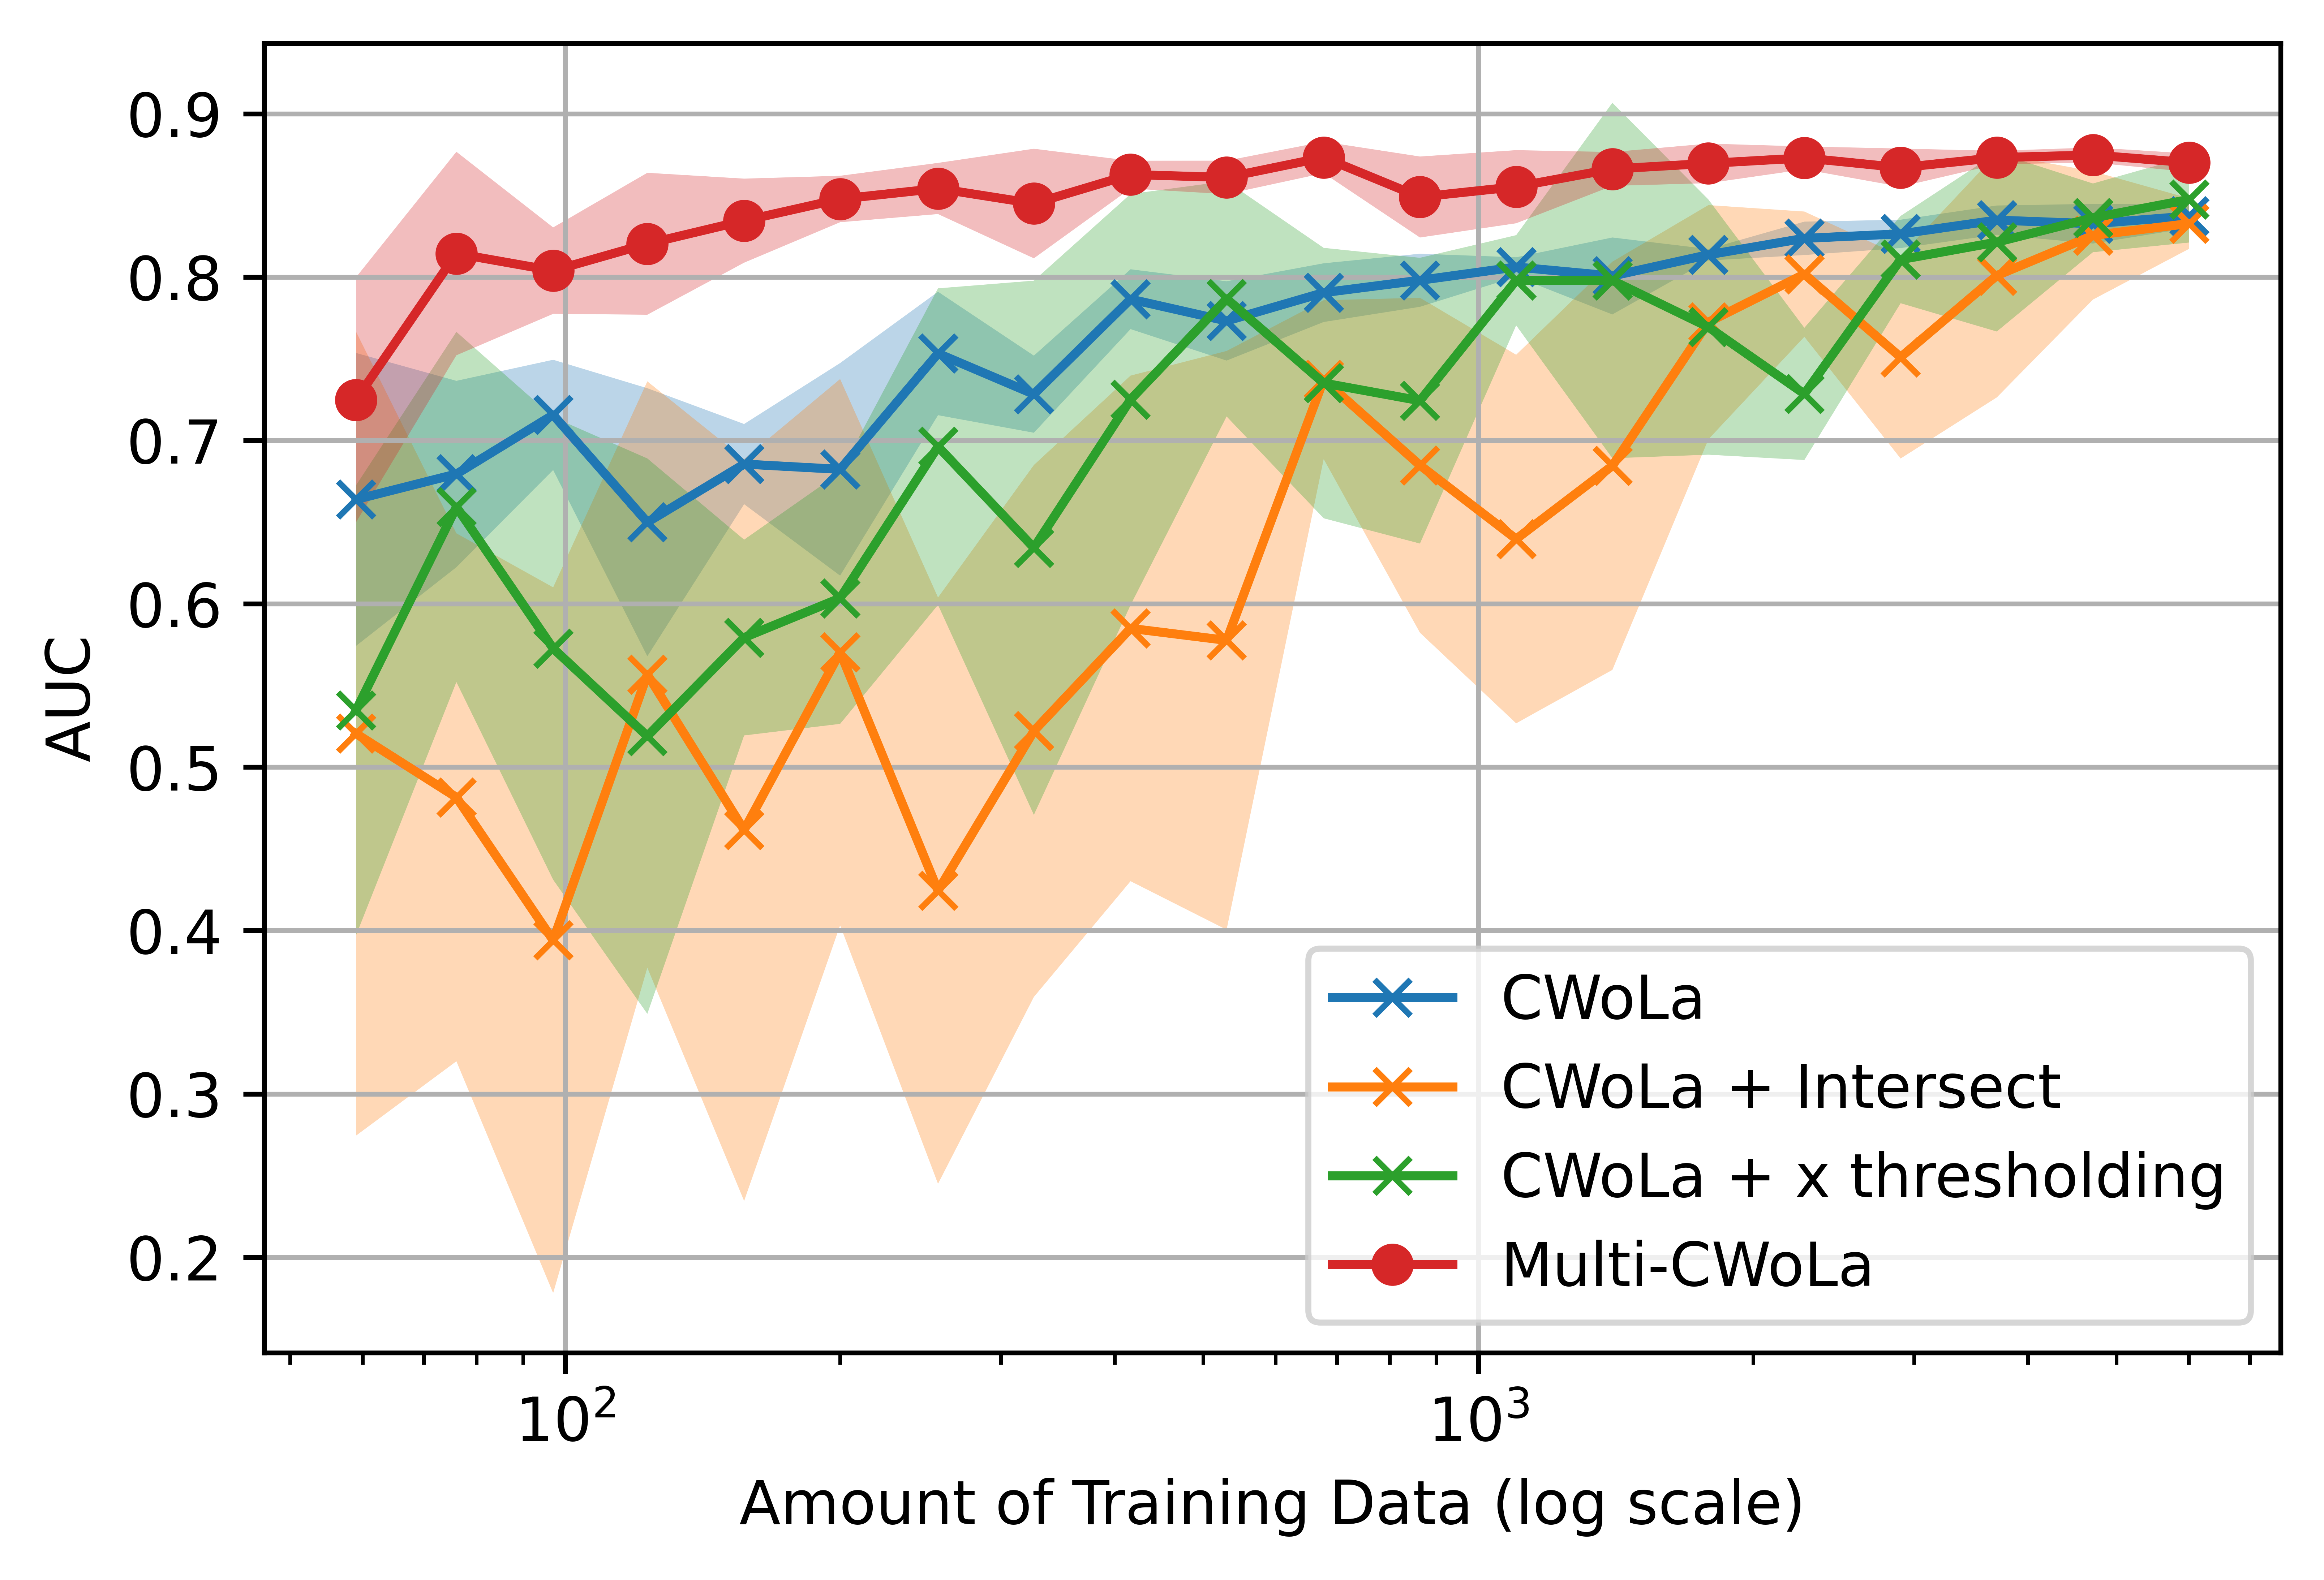

In [178]:
import matplotlib.pyplot as plt
plt.figure(dpi=1200)
fig = plt.gcf()
#f#ig.set_size_inches(18.5, 10.5)

n_labels = np.zeros(n_pts)

for a in range(len(n_ratios)):
    n1a = int(n_ratios[a]*n_train_anomaly)
    n2a = int(n_ratios[a]*n_train_background)
    n_labels[a] = n1a+n2a


plt.plot(n_labels, cwola_auc_mean, label='CWoLa', marker="x")
plt.fill_between(n_labels, cwola_auc_mean - cwola_auc_std, cwola_auc_mean + cwola_auc_std, alpha=0.3)

plt.plot(n_labels, intersect_auc_mean, label='CWoLa + Intersect', marker="x")
plt.fill_between(n_labels, intersect_auc_mean - intersect_auc_std, intersect_auc_mean + intersect_auc_std, alpha=0.3)

plt.plot(n_labels, disc_thresh_auc_mean, label='CWoLa + x thresholding', marker="x")
plt.fill_between(n_labels, disc_thresh_auc_mean - disc_thresh_auc_std, disc_thresh_auc_mean + disc_thresh_auc_std, alpha=0.3)

plt.plot(n_labels, snorkel_auc_mean, label='Multi-CWoLa', marker="o")
plt.fill_between(n_labels, snorkel_auc_mean - snorkel_auc_std, snorkel_auc_mean + snorkel_auc_std, alpha=0.3)


plt.ylabel('AUC')
plt.xlabel('Amount of Training Data (log scale)')

plt.legend(loc="lower right")
plt.grid()
ax = fig.axes[0]
ax.set_rasterized(True)
ax.set_xscale('log')


#plt.savefig("./figs/multicwola_final.pdf", bbox_inches='tight')

In [179]:
with open('cwola_auc_mean_final.npy', 'wb') as f:
    np.save(f, cwola_auc_mean)
    
with open('cwola_auc_std_final.npy', 'wb') as f:
    np.save(f, cwola_auc_std)
    


In [180]:
with open('intersect_auc_mean_final.npy', 'wb') as f:
    np.save(f, intersect_auc_mean)
    
with open('intersect_auc_std_final.npy', 'wb') as f:
    np.save(f, intersect_auc_std)
    


In [181]:
with open('disc_thresh_auc_mean_final.npy', 'wb') as f:
    np.save(f, disc_thresh_auc_mean)
    
with open('disc_thresh_auc_std_final.npy', 'wb') as f:
    np.save(f, disc_thresh_auc_std)
    


In [182]:
with open('snorkel_auc_mean_final.npy', 'wb') as f:
    np.save(f, snorkel_auc_mean)
    
with open('snorkel_auc_std_final.npy', 'wb') as f:
    np.save(f, snorkel_auc_std)
    


In [183]:
with open('mv_auc_mean_final.npy', 'wb') as f:
    np.save(f, mv_auc_mean)
    
with open('mv_auc_std_final.npy', 'wb') as f:
    np.save(f, mv_auc_std)
    
